# Plotting data, uncertainty, curve fits

The bread-and-butter of any experimental scientist is plotting data and visualizing uncertainty in that data. Often, we also want to fit a curve to that data and extract some model parameters for comparing different conditions. We'll work through a few ways to do that here. 

## Plotting mean +/- standard deviation
First, let's say we have some data, such as spectra, that we want to average and plot with its standard deviation. Let's generate some fake normally-distributed data with uniformly-distributed noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import scipy.optimize as opt
np.random.seed(42)

# Define a normal distribution
def normal(x,μ,σ):
    return 1/ (2*np.pi*σ**2)*np.exp(-(x-μ)**2/(2*σ**2))

mu1 = 530
mu2 = 560
sigma = 10
wavelengths = np.arange(500,600,10)
n_wvs = len(wavelengths)
fluorescence1 = 1000*normal(wavelengths,mu1,sigma)
fluorescence2 = 1000*normal(wavelengths,mu2,sigma)

Let's say we have three replicate spectra for each of two different conditions. Let's put them into a numpy array with each replicate in a column. Note that, because of how numpy and matplotlib handle vectors (such as "wavelengths" above), it really will be easiest if your data is arranged with samples in columns.

Of course, you wouldn't be assembling your data this way, you would just import it from your file and put it in a similar numpy array.

In [2]:
n_reps = 3
data1 = np.tile(fluorescence1,[n_reps,1]).T + np.random.rand(n_wvs,n_reps)
data2 = np.tile(fluorescence2,[n_reps,1]).T + np.random.rand(n_wvs,n_reps)
data = np.append(data1,data2,1)
print(pd.DataFrame(data)) # The pandas "DataFrame" call is just to make the data easier to visualize

          0         1         2         3         4         5
0  0.392221  0.968395  0.749674  0.607545  0.170524  0.065052
1  0.814051  0.371411  0.371387  0.948891  0.965638  0.808403
2  1.023407  1.831500  1.566439  0.305148  0.098206  0.684767
3  2.299622  1.612134  2.561459  0.457833  0.139719  0.512857
4  1.797766  1.177663  1.147148  0.249781  1.124713  0.474173
5  0.398797  0.519635  0.740149  1.627846  1.277035  1.485392
6  0.449626  0.308910  0.629533  2.138260  1.776404  2.561134
7  0.140028  0.292679  0.366896  1.740456  1.904822  1.860151
8  0.456076  0.785182  0.199680  0.813293  1.137267  0.303885
9  0.514234  0.592415  0.046450  0.213663  0.062908  0.343011


First, let's take the average and standard deviation across the replicates by specifying "axis = 1". Using "0" instead would have taken the average down each column. Specifying nothing would take the average of the whole array!

In [3]:
mn1 = np.mean(data[:,:n_reps], axis=1) #Note that we also could have done "data.mean(1)"
sd1 = np.std(data[:,:n_reps], axis=1) #Same here with "data.std(1)"

mn2 = data[:,n_reps:].mean(1)
sd2 = data[:,n_reps:].std(1)

We can plot the mean of each point with error bars, or we can plot the mean as a continuous line with a shaded region indicating the SD.

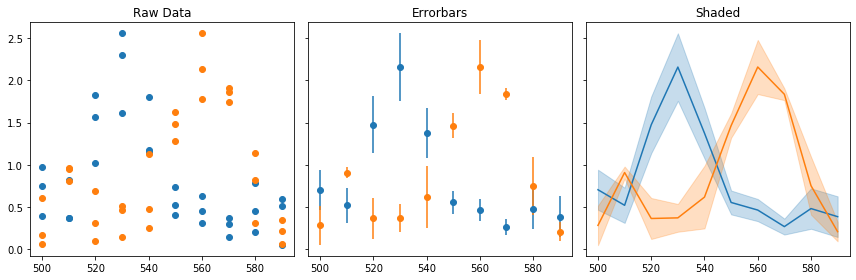

In [4]:
fig,(raw_ax, ebar_ax, shade_ax) = plt.subplots(1, 3, sharex = 'all', sharey = 'all', figsize = (12,4))

raw_ax.plot(wavelengths,data[:,:n_reps],'o',color = 'C0')
raw_ax.plot(wavelengths,data[:,n_reps:],'o',color = 'C1')
raw_ax.set_title('Raw Data')

ebar_ax.errorbar(wavelengths, mn1, sd1, marker = 'o', ls = 'none')
ebar_ax.errorbar(wavelengths, mn2, sd2, marker = 'o', ls = 'none')
ebar_ax.set_title('Errorbars')

shade_ax.plot(wavelengths,mn1)
shade_ax.fill_between(wavelengths, mn1 + sd1, mn1 - sd1, color = 'C0', alpha = 0.25, edgecolor = 'none')
shade_ax.plot(wavelengths,mn2)
shade_ax.fill_between(wavelengths, mn2 + sd2, mn2 - sd2, color = 'C1', alpha = 0.25, edgecolor = 'none')
shade_ax.set_title('Shaded')

fig.tight_layout() # When using subplots, you'll almost always want to call this *after* specifying titles, axes labels, etc

## Fitting a simple line to your data

First, some fake linear data with normally-distributed scatter:

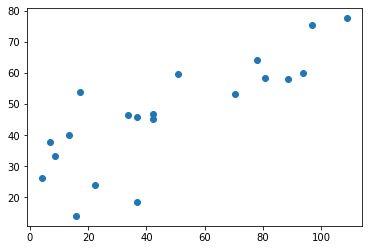

In [5]:
intercept_true = 25
slope_true = 0.5
x = 100 * np.random.random(20)
y = intercept_true + slope_true * x

# add scatter to points
x = np.random.normal(x, 10)
y = np.random.normal(y, 10)

plt.plot(x, y, 'o');

Estimated slope: 0.42
Estimated intercept: 26.98


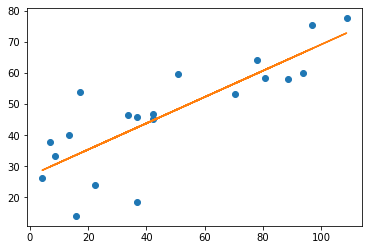

In [6]:
p_fit_lin,p_cov_lin = np.polyfit(x,y,1, cov = True)
[slope_est,intercept_est] = p_fit_lin
print('Estimated slope: {:.2f}'.format(slope_est))
print('Estimated intercept: {:.2f}'.format(intercept_est))
lin_fit = np.poly1d([slope_est,intercept_est]) # also could have done np.poly1d(*p_fit)
plt.plot(x,y,'o')
plt.plot(x,lin_fit(x));

In [7]:
x = x
y = y

residuals_lin = y - lin_fit(x)
ss_res_lin = np.sum(residuals_lin**2)
ss_tot_lin = np.sum((y-np.mean(y))**2)
r2_lin = 1 - (ss_res_lin / ss_tot_lin)       # R^2, a measure of correlation
print('R^2 = {:.3f}'.format(r2_lin))

R^2 = 0.662


The 95% Confidence Interval, which reflects the probability of the value predicted by the fit ($\mu$) at each point $x_0$ is calculated from the 97.5 percentile of a Student's t-distribution with n-m degrees of freedom ($T_{n-m}^{.975}$):

$$ \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-m}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}} $$

$$ \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}} $$

And the 95% Prediction Interval, which reflects the probability of where new observations might lie, is give by:

$$ \left| \: \hat{y}_0 - y_0 \: \right| \; \leq \; T_{n-m}^{.975} \; \hat{\sigma} \; \sqrt{1 + \frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}} $$

(Taken from M. Duarte.  "Curve fitting," Jupyter Notebook. http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb as well as https://stackoverflow.com/a/28336695)

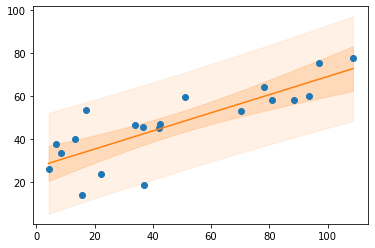

In [8]:
n = y.size
m = p_fit_lin.size
dof_lin = n-m                                # Degrees of freedom
t = stats.t.ppf(0.975, n - m)                # Student's t distribution
chi2 = np.sum((residuals_lin / lin_fit(x))**2)          # chi-squared; estimates error in data
chi2_red = chi2 / dof_lin                        # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(residuals_lin**2) / dof_lin)      # standard error of the fit at each point
p_std_lin = np.sqrt(np.diag(p_cov_lin))      # Uncertainty on each output parameter

def CI(x, xplot, t, s_err, n):
    return t * s_err * np.sqrt(1/n + (xplot - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

def PI(x, xplot, t, s_err, n):
    return t * s_err * np.sqrt(1 + 1/n + (xplot - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

xplot = np.linspace(x.min(),x.max(),100)
ci_lin = CI(x,xplot,t, s_err, n)
pi_lin = PI(x,xplot,t, s_err, n)
yplot = lin_fit(xplot)

plt.plot(x,y,'o')
plt.fill_between(xplot, yplot + pi_lin, yplot - pi_lin, color = 'C1', alpha = 0.1)
plt.fill_between(xplot, yplot + ci_lin, yplot - ci_lin, color = 'C1', alpha = 0.2)
plt.plot(xplot,yplot, color = 'C1');

## Fitting a more complicated curve to your data
Let's say you have data from a logistic curve



In [34]:
def Hill_eq(x,S0,Smax,x_inflect,b):
    return S0 + ( Smax - S0 )/( 1 + 10**(x_inflect-x)*b )

c = concentrations = 10**-np.arange(5.,12.)
lg_c = np.log10(c)
r = response = Hill_eq(lg_c,0.3,1.5,-8,1.4)

n_reps = 3
data = np.tile(r,[n_reps,1]).T + np.random.rand(c.size,n_reps)*0.2

# Guess parameters
S0_g = data.min()
Smax_g = data.max()
x_inflect_g = lg_c[np.argmax(r < (Smax_g-S0_g)/2+S0_g)]
b_g = 1

flat_lg_c = np.tile(lg_c,[3,1]).T.flatten()
flat_data = data.flatten()

Hill_eq(tile_lg_c,0.3,1.5,-8,1.4)

p_opt_Hill, p_cov_Hill = opt.curve_fit(Hill_eq, flat_lg_c, flat_data,
                                       p0 = (S0_g, Smax_g, x_inflect_g, b_g))
print(p_opt_Hill)

[ 0.37755976  1.62940138 -7.74053202  0.89280946]


C:\Users\johng\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  


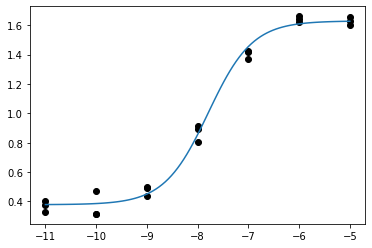

In [35]:
cplot = np.linspace(lg_c.min(),lg_c.max(),100)

hill_y = Hill_eq(cplot,*p_opt_Hill)

plt.plot(lg_c,data,'ko')
plt.plot(cplot,hill_y,'C0')

In [32]:
def fit_intervals(func,p_opt,x,y,xplot):
    res = y - func(x,*p_opt)
    n = y.size
    m = p_opt.size
    dof = n-m                                # Degrees of freedom
    t = stats.t.ppf(0.975, n - m)                # Student's t distribution
    chi2 = np.sum((res / func(x,*p_opt))**2)          # chi-squared; estimates error in data
    chi2_red = chi2 / dof                   # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(res**2) / dof)      # standard error of the fit at each point

    ci = t * s_err * np.sqrt(1/n + (xplot - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

    pi = t * s_err * np.sqrt(1 + 1/n + (xplot - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

    return ci, pi

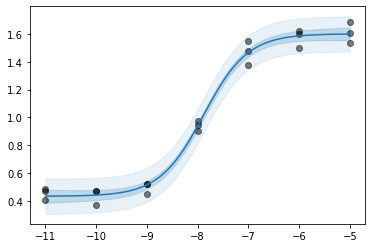

In [33]:
hill_ci, hill_pi = fit_intervals(Hill_eq,p_opt_Hill,flat_lg_c,flat_data,cplot)

plt.plot(lg_c,data,'ko', alpha = 0.5)
plt.fill_between(cplot, hill_y + hill_pi, hill_y - hill_pi, color = 'C0', alpha = 0.1)
plt.fill_between(cplot, hill_y + hill_ci, hill_y - hill_ci, color = 'C0', alpha = 0.2)
plt.plot(cplot,hill_y,'C0');